In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load your preprocessed data
df = pd.read_csv("Preprocessed_Data_with_features.csv", index_col=0)
df = df.dropna()

# Features to use
features = ['Price', 'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_signal', 'Bollinger_High',
            'Bollinger_Low', 'ATR_14', 'Momentum_10']

X = df[features].values
y = df['Return'].values

# Scaling features for LSTM
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for LSTM (e.g., 30-day window)
def create_sequences(X, y, window=30):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y, window=30)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0060 - val_loss: 1.7499e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.3168e-04 - val_loss: 8.1112e-05
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.6796e-04 - val_loss: 3.7415e-05
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.8006e-04 - val_loss: 3.6105e-05
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.1160e-04 - val_loss: 5.5726e-05
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.5632e-04 - val_loss: 3.5361e-05
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.3183e-04 - val_loss: 5.2316e-05
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.0461e-04 - val_loss: 4.1380e-05
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.0084e-04 - val_loss: 3.9196e-05
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.5639e-04 - val_loss: 3.5478e-05
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.5440e-04 - 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE       : 0.000063
Sharpe Ratio   : -0.5490
Max Drawdown   : -0.1463


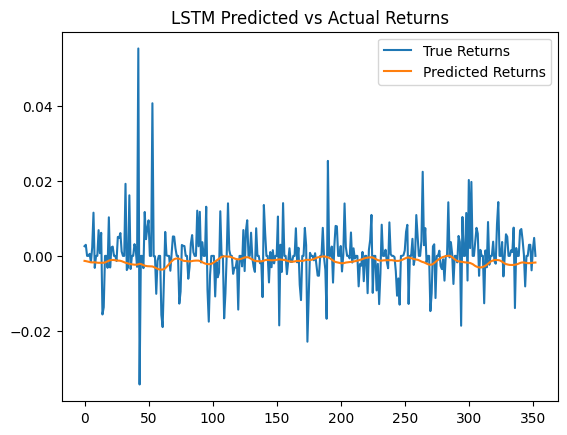

In [ ]:
# Predict
y_pred = model.predict(X_test).flatten()

# Evaluation Metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# MSE
mse = mean_squared_error(y_test, y_pred)

# Sharpe Ratio and Max Drawdown
def sharpe_ratio(returns):
    mean_ret = np.mean(returns)
    std_ret = np.std(returns)
    return (mean_ret / std_ret) * np.sqrt(252)

strategy_returns = np.where(y_pred > 0, y_test, -y_test)

cumulative = np.cumsum(strategy_returns)
running_max = np.maximum.accumulate(cumulative)
drawdown = cumulative - running_max
max_drawdown = drawdown.min()

sharpe = sharpe_ratio(strategy_returns)

# Results
print(f"Test MSE       : {mse:.6f}")
print(f"Sharpe Ratio   : {sharpe:.4f}")
print(f"Max Drawdown   : {max_drawdown:.4f}")

# Plot actual vs predicted returns
plt.plot(y_test, label='True Returns')
plt.plot(y_pred, label='Predicted Returns')
plt.legend()
plt.title("LSTM Predicted vs Actual Returns")
plt.show()


**Blue Line (True Returns)**:

* High volatility with frequent sharp spikes and drops.

* Represents actual market return behavior—noisy and erratic.

**Orange Line (Predicted Returns)**:

* Smooth, low-volatility predictions.

* The model fails to capture the amplitude of actual returns.

* Indicates underfitting—the model is too conservative.

##Model Interpretation:

**Underfitting**:
The model is too smooth and does not capture the complexity or volatility of the true returns.

**Risk-Reward Profile**:
A negative Sharpe Ratio and sizable drawdown suggest that the model would perform poorly in real-world trading or investing scenarios.

**Low Practical Value**:
While the test MSE appears low, the lack of ability to capture meaningful return movements makes the model ineffective for financial decision-making.

In [ ]:
import pickle
from google.colab import files

# Save the model
with open('LSTM_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Download the file to your PC
files.download('LSTM_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>